In [9]:
import pandas as pd
from pycaret.regression import *
from datetime import datetime, time

from google.cloud import bigquery
from google.oauth2 import service_account
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
from numpy import mean , concatenate
from math import sqrt
from sklearn.metrics       import mean_absolute_error,r2_score

from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

look_ahead=24 # Predict next look_ahead values

In [ ]:
path_to_private_key = './ieso-dashboard-c639f1a39298.json'
credentials = service_account.Credentials.from_service_account_file(
    path_to_private_key,
    scopes=['https://www.googleapis.com/auth/cloud-platform'],
)

### Independent/ Input Variables 

In [ ]:
# OLD DATA from csv file
old_ade=pd.read_csv('adequacy_202209052348.csv')
old_ade['mkt_datetime']=old_ade['mkt_datetime'].map(lambda x: datetime.strptime(x,'%m/%d/%Y %H:%M').isoformat(timespec='minutes'))

In [ ]:
# CURRENT DATA from bigQuery
query_string="SELECT * FROM `ieso-dashboard.Adequacy2.Adequacy2_table` ORDER BY mkt_date, mkt_he;"
gbq_ade = pd.read_gbq(query_string, credentials=credentials)

In [ ]:
hour_col = gbq_ade['mkt_he'].apply(lambda x: str(x-1)+":00")
date_col = gbq_ade['mkt_date'].apply(lambda x: str(x))

date_time=pd.to_datetime(date_col +' '+ hour_col).map(lambda x: x.isoformat(timespec='minutes'))

gbq_ade.insert(loc = 0,
          column = 'mkt_datetime',
          value = date_time)
# gbq_ade['mkt_datetime']=date_time

In [ ]:
ind_var = ['mkt_datetime','int_nuc_cap','int_nuc_out','int_nuc_off','int_nuc_sch','int_gas_cap','int_gas_out','int_gas_off','int_gas_sch','int_hyd_cap','int_hyd_out','int_hyd_for','int_hyd_off','int_hyd_sch','int_win_cap','int_win_out','int_win_for','int_win_sch','int_sol_cap','int_sol_out','int_sol_for','int_sol_sch','int_bio_cap','int_bio_out','int_bio_off','int_bio_sch','int_oth_cap','int_oth_out','int_oth_off','int_oth_sch','int_tot_out','int_tot_off','int_tot_sch','imp_man_off','imp_man_sch','imp_min_off','imp_min_sch','imp_mic_off','imp_mic_sch','imp_new_off','imp_new_sch','imp_que_off','imp_que_sch','imp_tot_off','imp_tot_sch','imp_tot_est','imp_tot_cap','ont_bot_cap','ont_reg','ont_tot_sup','ont_for_dem','ont_peak_dem','ont_avg_dem','ont_emb_wind','ont_emb_sol','ont_disp_cap','ont_disp_bid','ont_disp_on','ont_disp_off','ont_hdr_bid','ont_hdr_sch','ont_hdr_cur','exp_man_bid','exp_man_sch','exp_min_bid','exp_min_sch','exp_mic_bid','exp_mic_sch','exp_new_bid','exp_new_sch','exp_que_bid','exp_que_sch','exp_tot_bid','exp_tot_sch','exp_tot_cap','grh_tot','grh_min_10n','grh_min_10s','grh_lfu','grh_add','total_req','cap_excess','energy_excess','offered_cap_excess','res_not_sch','imp_not_sch']
X_curr = gbq_ade[ind_var]
X_old = old_ade[ind_var]

In [ ]:
X1=X_curr[X_curr['mkt_datetime']>max(X_old['mkt_datetime'])]  # which is '2022-09-06T23:00'
X_combined = pd.concat([X_old, X1], ignore_index=True)

In [ ]:
X_combined.loc[:,ind_var] = X_combined.loc[:,ind_var].ffill()
X=X_combined.dropna() # includes all days from 1/1/20 till current date

### Target Variable (ont_ene)

In [ ]:
## CURRENT DATA being fetched from bigQuery
query_string="SELECT * FROM `ieso-dashboard.RealtimeMktPrice.RealtimeMktPrice_table` ORDER BY mkt_date, mkt_he;"
gbq_rtmp = pd.read_gbq(query_string, credentials=credentials)

In [ ]:
hour_col = gbq_rtmp['mkt_he'].apply(lambda x: str(x-1)+":00")
date_col = gbq_rtmp['mkt_date'].apply(lambda x: str(x))

date_time=pd.to_datetime(date_col +' '+ hour_col).map(lambda x: x.isoformat(timespec='minutes'))

gbq_rtmp.insert(loc = 0,
          column = 'mkt_datetime',
          value = date_time)

In [ ]:
dep_var = ['mkt_datetime','ont_ene']
Y_curr = gbq_rtmp[dep_var]

In [ ]:
## OLD DATA
old_rtmp=pd.read_csv('historical ont_ene.csv')
hour_col = old_rtmp['he'].apply(lambda x: str(x-1)+":00")
date_col = old_rtmp['mkt_date'].apply(lambda x: str(x))

date_time=pd.to_datetime(date_col +' '+ hour_col).map(lambda x: x.isoformat(timespec='minutes'))
old_rtmp.insert(loc = 0,
          column = 'mkt_datetime',
          value = date_time)

In [ ]:
val_to_fillna=old_rtmp[old_rtmp['mkt_date']=='2022-05-20'].ont_ene.mean()
old_rtmp.at[20893,'ont_ene']=val_to_fillna
old_rtmp.at[20894,'ont_ene']=val_to_fillna
old_rtmp.at[20895,'ont_ene']=val_to_fillna

# old_rtmpold_rtmp['mkt_datetime']=='2022-05-20T14:00']['ont_ene']=val_to_fillna
# old_rtmp[old_rtmp['mkt_datetime']=='2022-05-20T15:00']['ont_ene']=val_to_fillna
old_rtmp=old_rtmp.dropna()

In [ ]:
Y_old = old_rtmp[dep_var]
Y1=Y_curr[Y_curr['mkt_datetime']>max(Y_old['mkt_datetime'])]  # which is '2022-09-07T10:00'
Y_combined = pd.concat([Y_old, Y1], ignore_index=True)

In [ ]:
Y=Y_combined.dropna() # includes all days from 1/1/20 till current date

### Merging all the columns

In [ ]:
X[X['mkt_datetime'].duplicated() == True]

In [ ]:
X.at[1610,'mkt_datetime']='2020-03-08T02:00'
X.at[10514,'mkt_datetime']='2021-03-14T02:00'
X.at[19250,'mkt_datetime']='2022-03-13T02:00'

In [ ]:
X['mkt_datetime'] = pd.to_datetime(X.mkt_datetime)
Y['mkt_datetime'] = pd.to_datetime(Y.mkt_datetime)

merged_data = pd.merge(X,Y,how='left',on = 'mkt_datetime')
merged_data=merged_data.set_index('mkt_datetime')

In [2]:
# Loading the data
data=merged_data.copy()

# [Feature Engineering]
data.loc[data['ont_ene']<0,'ont_ene']=0 # Lower bound values to zero.... Corrects for the -ve values
mean=data['ont_ene'].mean() # Clipping outliers using z-score analysis
std=data['ont_ene'].std()

upperlimit=mean + 3 * std
data.loc[data['ont_ene']>upperlimit,'ont_ene']=upperlimit # Can try setting it None and fill forward

In [3]:
train=data.dropna()

In [10]:
test=data[data.ont_ene.isnull()].iloc[:look_ahead,:]

In [6]:
s = setup(data = train, target = 'ont_ene', session_id=123, normalize=True, silent=True, numeric_features=['int_nuc_cap','int_nuc_out','int_nuc_off','int_nuc_sch','int_gas_cap','int_gas_out','int_gas_off','int_gas_sch','int_hyd_cap','int_hyd_out','int_hyd_for','int_hyd_off','int_hyd_sch','int_win_cap','int_win_out','int_win_for','int_win_sch','int_sol_cap','int_sol_out','int_sol_for','int_sol_sch','int_bio_cap','int_bio_out','int_bio_off','int_bio_sch','int_oth_cap','int_oth_out','int_oth_off','int_oth_sch','int_tot_out','int_tot_off','int_tot_sch','imp_man_off','imp_man_sch','imp_min_off','imp_min_sch','imp_mic_off','imp_mic_sch','imp_new_off','imp_new_sch','imp_que_off','imp_que_sch','imp_tot_off','imp_tot_sch','imp_tot_est','imp_tot_cap','ont_bot_cap','ont_reg','ont_tot_sup','ont_for_dem','ont_peak_dem','ont_avg_dem','ont_emb_wind','ont_emb_sol','ont_disp_cap','ont_disp_bid','ont_disp_on','ont_disp_off','ont_hdr_bid','ont_hdr_sch','ont_hdr_cur','exp_man_bid','exp_man_sch','exp_min_bid','exp_min_sch','exp_mic_bid','exp_mic_sch','exp_new_bid','exp_new_sch','exp_que_bid','exp_que_sch','exp_tot_bid','exp_tot_sch','exp_tot_cap','grh_tot','grh_min_10n','grh_min_10s','grh_lfu','grh_add','total_req','cap_excess','energy_excess','offered_cap_excess','res_not_sch','imp_not_sch'])

,Description,Value
0,session_id,123
1,Target,ont_ene
2,Original Data,"(24315, 86)"
3,Missing Values,False
4,Numeric Features,85
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(17020, 82)"


In [7]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.3820,140.1315,11.8377,0.7650,0.6151,0.7664
1,6.0769,110.1250,10.4940,0.8223,0.6056,0.6457
2,6.3100,113.5886,10.6578,0.8135,0.6733,0.7454
3,6.1832,114.4261,10.6970,0.8197,0.6415,0.6421
4,6.1308,130.4915,11.4233,0.8001,0.6143,0.6089
5,6.2385,122.0842,11.0492,0.7886,0.6396,0.7850
6,6.7354,150.4547,12.2660,0.7734,0.6256,0.6298
7,6.5650,128.1263,11.3193,0.7864,0.6606,0.9209
8,6.4375,135.6308,11.6461,0.7838,0.5831,0.6282


In [8]:
tuned_rf=tune_model(rf,n_iter = 3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.2292,156.6365,12.5154,0.7374,0.7050,0.8131
1,6.7974,131.6910,11.4757,0.7875,0.6866,0.7223
2,7.0550,133.6597,11.5611,0.7805,0.7490,0.8405
3,6.8856,124.9236,11.1769,0.8032,0.7249,0.7246
4,6.9576,146.3731,12.0985,0.7758,0.6957,0.6979
5,7.0621,137.2065,11.7135,0.7625,0.7312,0.8988
6,7.4652,165.0227,12.8461,0.7514,0.7088,0.7117
7,7.4169,145.9269,12.0800,0.7568,0.7509,1.0176
8,7.1790,152.1934,12.3367,0.7574,0.6765,0.7149


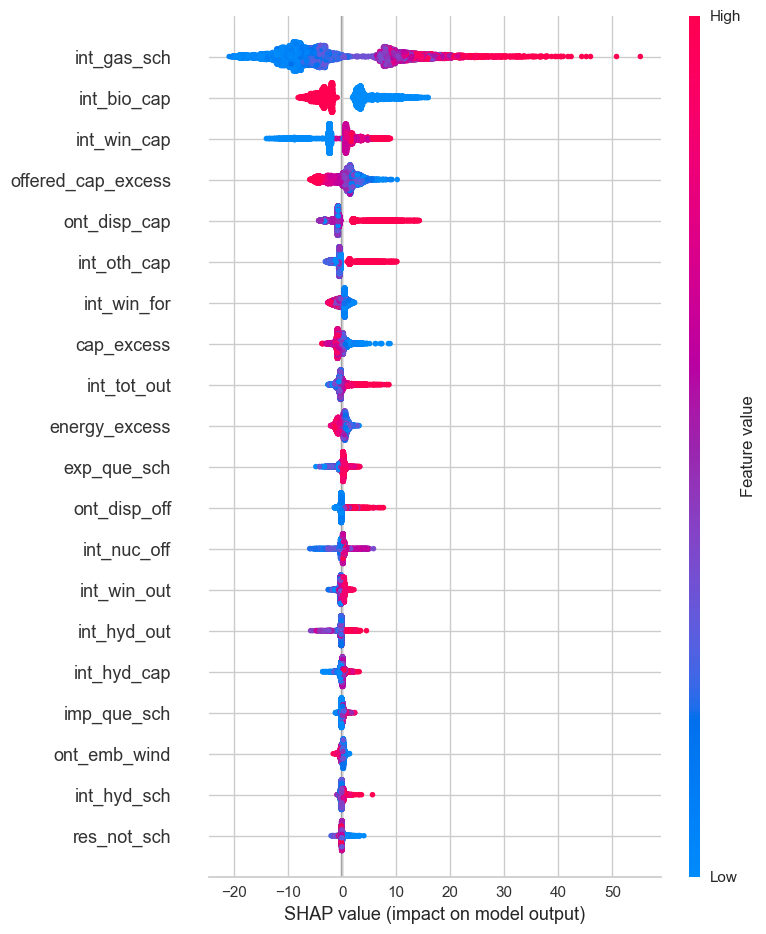

In [9]:
# interpret_model(tuned_rf)

In [11]:
save_model(tuned_rf,'reg_rf_v1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['int_nuc_cap',
                                                           'int_nuc_out',
                                                           'int_nuc_off',
                                                           'int_nuc_sch',
                                                           'int_gas_cap',
                                                           'int_gas_out',
                                                           'int_gas_off',
                                                           'int_gas_sch',
                                                           'int_hyd_cap',
                                                           '

In [25]:
preds_df=(predict_model(tuned_rf, data = test)['Label']).to_frame(name='ont_ene_pred')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0,0,0,0,0,0


In [28]:
preds_df

,ont_ene_pred
mkt_datetime,
2022-10-10 03:00:00,48.541014
2022-10-10 04:00:00,47.250440
2022-10-10 05:00:00,53.787598
2022-10-10 06:00:00,56.871947
2022-10-10 07:00:00,57.510874
2022-10-10 08:00:00,57.281067
2022-10-10 09:00:00,57.414620
2022-10-10 10:00:00,57.006050
2022-10-10 11:00:00,57.657062
